In [58]:
# !pip install -v python-mecab-ko

SyntaxError: invalid syntax (4152693378.py, line 1)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint.33 +-0-+


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x14378a0ad90>)

# Data Load

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['sentence']

In [8]:
data[:5]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['kor_sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4827


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서..."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로..."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [14]:
# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4827


<AxesSubplot: >

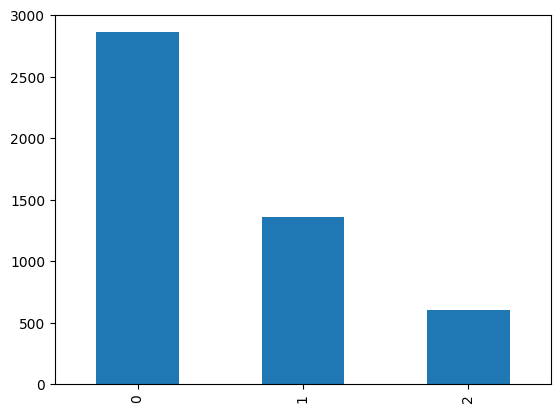

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0   2861
1       1   1362
2       2    604


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [18]:
mecab = mecab.MeCab()

In [19]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [20]:
data.head(1)

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...","[Gran, 에, 따르, 면, ,, 그, 회사, 는, 회사, 가, 성장, 하, 고,..."


# 훈련-테스트

In [21]:
X_data = data['tokenized']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4827
레이블의 개수: 4827


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [23]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3861
테스트 샘플의 개수 : 966


In [24]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.285%
긍정 = 28.205%
부정 = 12.51%


In [25]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.213%
긍정 = 28.261%
부정 = 12.526%


# tokenize

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[390, 199, 4, 299, 170, 128, 2, 150, 15, 299, 170, 2075, 331, 10, 4, 1156, 5, 567, 29, 20, 22, 151, 10, 16, 14, 3, 1], [1157, 1158, 4, 92, 5, 43, 36, 50, 13, 47, 208, 16, 13, 3, 1], [5, 95, 2, 55, 7, 19, 1, 38, 44, 15, 48, 1, 52, 44, 22, 50, 13, 3, 1], [515, 4, 2076, 4504, 6, 84, 283, 157, 8, 609, 638, 160, 2, 2480, 474, 1066, 157, 6, 2077, 29, 20, 8, 284, 13, 3, 1], [165, 339, 7, 1426, 265, 76, 15, 1426, 332, 76, 699, 18, 475, 212, 1]]
[[868, 792, 7, 113, 140, 6, 88, 332, 27, 17, 12, 114, 77, 1], [97, 1917, 211, 184, 2, 4295, 2503, 23, 401, 24, 770, 6, 174, 364, 34, 16, 190, 61, 20, 5, 69, 28, 330, 7, 51, 13, 3, 1], [672, 160, 376, 882, 30, 238, 31, 4, 156, 2, 3463, 1088, 5, 21, 5286, 159, 2, 964, 12, 2873, 10, 4, 20, 5, 69, 1143, 13, 3, 1], [412, 38, 65, 150, 7, 58, 11, 231, 95, 2, 19, 1, 48, 206, 17, 15, 19, 1, 43, 206, 17, 18, 452, 3, 1], [71, 11, 43, 26, 511, 40, 653, 19, 205, 98, 571, 105, 1, 5241, 2, 1196, 328, 3118, 19, 37, 71, 6, 84, 271, 2474, 7, 71, 11, 19, 26, 123, 38, 26,

In [27]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

8942


# 패딩

In [28]:
X_train[:2]

2049    [보험, 사, 는, 노르, 데, 아, 의, 순이익, 에서, 노르, 데, 아가, 차지...
129     [백화점, 부서, 는, 매출, 이, 4, %, 증가, 했, 다고, 보, 고, 했, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 76
본문의 평균 길이 : 28.235431235431236


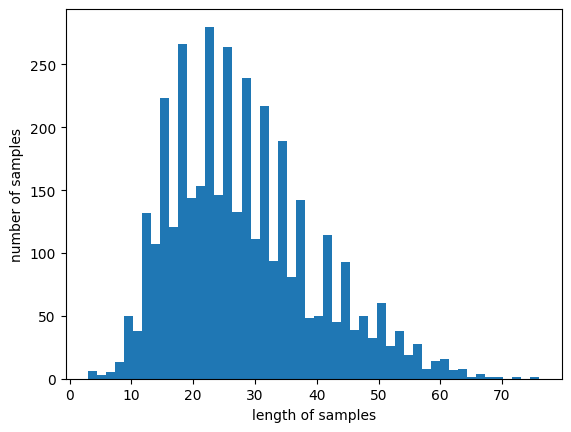

In [29]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
max_len = 76

In [31]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [32]:
X_train_encoded.shape

(3861, 76)

In [33]:
X_test_encoded.shape

(966, 76)

In [34]:
X_test[:1]

2347    [합작, 법인, 은, 곧바로, 생산, 기술, 에, 약, 50, 만, 유로, 를, 투...
Name: tokenized, dtype: object

In [35]:
X_train_encoded[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  390,  199,    4,  299,  170,  128,
           2,  150,   15,  299,  170, 2075,  331,   10,    4, 1156,    5,
         567,   29,   20,   22,  151,   10,   16,   14,    3,    1]])

In [36]:
y_test[8]

1

In [37]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델

In [38]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
97/97 [==============================] - ETA: 0s - loss: 0.8867 - acc: 0.6101
Epoch 1: val_acc improved from -inf to 0.70763, saving model to best_model.h5
97/97 [==============================] - 5s 32ms/step - loss: 0.8867 - acc: 0.6101 - val_loss: 0.7119 - val_acc: 0.7076
Epoch 2/15
97/97 [==============================] - ETA: 0s - loss: 0.6080 - acc: 0.7341
Epoch 2: val_acc improved from 0.70763 to 0.72704, saving model to best_model.h5
97/97 [==============================] - 3s 27ms/step - loss: 0.6080 - acc: 0.7341 - val_loss: 0.6754 - val_acc: 0.7270
Epoch 3/15
96/97 [============================>.] - ETA: 0s - loss: 0.3381 - acc: 0.8760
Epoch 3: val_acc did not improve from 0.72704
97/97 [==============================] - 3s 28ms/step - loss: 0.3382 - acc: 0.8756 - val_loss: 0.7772 - val_acc: 0.7141
Epoch 4/15
95/97 [============================>.] - ETA: 0s - loss: 0.1685 - acc: 0.9457
Epoch 4: val_acc did not improve from 0.72704
97/97 [==========================

In [39]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_encoded, y_test)[1]))

31/31 [==============================] - 1s 9ms/step - loss: 0.9107 - acc: 0.7712

 테스트 정확도: 0.7712


In [40]:
loaded_model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model=tf.keras.models.load_model(
    './NLP/best_model.h5')

In [43]:
model

# =============================================================================

# 데이터 로드

In [45]:
df = pd.read_excel('../데이터/기업별 뉴스/CMG제약.xlsx',   sheet_name='#02 Documents')
df.head(1)

,date,category,section,publisher,author,title,content_url,attachment,industry.label,industry.score,industry.name,polarity.label,polarity.score,polarity.name
0,2023-05-22,news,economy,조선비즈,NaN,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN,NaN,C21,0.969,의료용 물질 및 의약품 제조업,NaN,NaN,NaN


In [46]:
df = df[['date','title','polarity.label']]
df.head(1)


,date,title,polarity.label
0,2023-05-22,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN


# 데이터 라벨 값 변환

In [47]:
df['polarity.label'] = df['polarity.label'].replace(-1,2)

In [48]:
df['polarity.label'].unique()

array([nan,  1.,  0.,  2.])

# 중복값 확인

In [49]:
duplicate = df[df.duplicated()]
duplicate

,date,title,polarity.label


In [8]:
# polarity.label  = [긍정,중립,부정]
# polarity.name   = [1,0,2]

<AxesSubplot: >

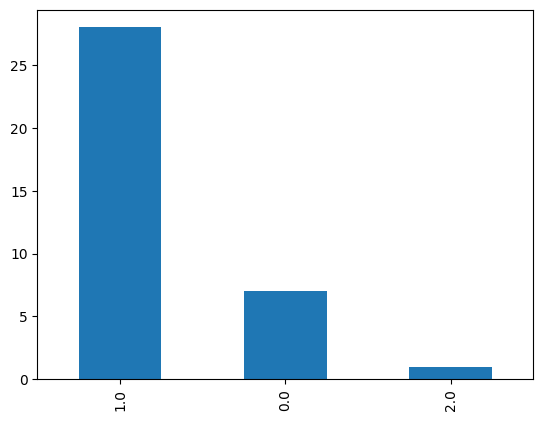

In [50]:
df['polarity.label'].value_counts().plot(kind='bar')

In [52]:
df['tokenized'] = df['title'].apply(mecab.morphs)

In [53]:
df.head(2)

,date,title,polarity.label,tokenized
0,2023-05-22,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,2023-05-05,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",NaN,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."


# 훈련-테스트

In [54]:
train = df[df['polarity.label'].notna()]
test = df[df['polarity.label'].isna()]

<AxesSubplot: >

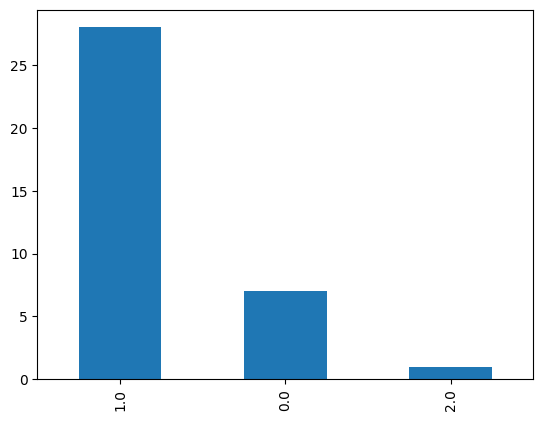

In [55]:
train['polarity.label'].value_counts().plot(kind='bar')

In [60]:
X_train_news = train['tokenized']
y_train_news = train['polarity.label']

In [61]:
X_test_news = test['tokenized']
y_test_news = test['polarity.label']

# 토크나이즈

In [62]:
X_train_news_en = tokenizer.texts_to_sequences(X_train_news)
X_test_news_en = tokenizer.texts_to_sequences(X_test_news)

In [63]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

8942


# 패딩

In [64]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train_news   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train_news)  )   /  len(X_train_news)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다

본문의 최대 길이 : 20
본문의 평균 길이 : 14.305555555555555


In [65]:
max_len = 20

In [66]:
X_train_news_en = pad_sequences(X_train_news_en, maxlen=max_len)
X_test_news_en = pad_sequences(X_test_news_en, maxlen=max_len)

In [67]:
X_train_news_en.shape

(36, 20)

In [68]:
X_test_news_en.shape

(24, 20)

In [71]:
# y_train_news = to_categorical(y_train_news)
# y_test_news = to_categorical(y_test_news)

ValueError: negative dimensions are not allowed

In [72]:
predict=model.predict(X_test_news_en)
predict

1/1 [==============================] - 3s 3s/step


array([[0.9859973 , 0.01014547, 0.00385714],
       [0.10415201, 0.85754955, 0.03829848],
       [0.9599374 , 0.02752489, 0.01253773],
       [0.94274956, 0.04222604, 0.01502445],
       [0.92745256, 0.05401395, 0.01853346],
       [0.8927773 , 0.0765273 , 0.03069535],
       [0.96954703, 0.02230941, 0.0081436 ],
       [0.9891722 , 0.00807706, 0.0027507 ],
       [0.81440014, 0.14927702, 0.03632282],
       [0.8984386 , 0.07479079, 0.02677058],
       [0.8522234 , 0.11971783, 0.02805877],
       [0.96729136, 0.02140551, 0.01130315],
       [0.98670524, 0.01007951, 0.00321523],
       [0.8999534 , 0.06260617, 0.03744047],
       [0.8513715 , 0.10732227, 0.0413062 ],
       [0.8721809 , 0.08079891, 0.04702019],
       [0.94294506, 0.03630428, 0.02075067],
       [0.9861152 , 0.01024295, 0.00364177],
       [0.9843338 , 0.01187286, 0.00379336],
       [0.9873037 , 0.00928018, 0.00341615],
       [0.6520718 , 0.18214056, 0.16578765],
       [0.97788006, 0.01616103, 0.00595898],
       [0.

In [74]:
labels = []
for pred in predict:
    label=np.argmax(pred)
    labels.append(label)

In [73]:
np.argmax(predict)

21

In [75]:
labels

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [77]:
test['polarity.label'] = labels

C:\Users\ASIA\AppData\Local\Temp\ipykernel_6264\4054918419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['polarity.label'] = labels


In [78]:
test

,date,title,polarity.label,tokenized
0,2023-05-22,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",0,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,2023-05-05,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",1,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."
6,2023-03-23,오늘은 ‘세계 강아지의 날’ “반려견 건강 챙겨주세요”,0,"[오늘, 은, ‘, 세계, 강아지, 의, 날, ’, “, 반려, 견, 건강, 챙겨,..."
7,2023-01-30,펫 의약품 가파른 성장세… 제약·바이오 기업 바빠졌다,0,"[펫, 의약품, 가파른, 성장세, …, 제약, ·, 바이오, 기업, 바빠졌, 다]"
8,2023-01-16,"안국약품, CMG제약과 고혈압·고지혈증 복합제 '아모르탄알정' 코프로모션",0,"[안국, 약품, ,, CMG, 제약, 과, 고, 혈압, ·, 고지혈증, 복합제, '..."
9,2022-12-19,"차바이오텍 CMG제약, 동물의약품 사업진출",0,"[차바, 이, 오텍, CMG, 제약, ,, 동물, 의약품, 사업, 진출]"
10,2022-12-19,"차바이오텍 계열사 CMG제약, 동물의약품 사업부 신설",0,"[차바, 이, 오텍, 계열사, CMG, 제약, ,, 동물, 의약품, 사업, 부, 신설]"
11,2022-12-15,CMG제약 “신약 개발로 2025년 연매출 2000억 30위권 제약사 도약”,0,"[CMG, 제약, “, 신약, 개발, 로, 2025, 년, 연매, 출, 2000, ..."
12,2022-12-15,"'ESG 늦바람' 제약바이오, 핵심은 '이것'",0,"[', ESG, 늦바람, ', 제약, 바이오, ,, 핵심, 은, ', 이것, ']"
13,2022-12-08,"안국약품, CMG제약과 정장제 '락비오캡슐' 코프로모션",0,"[안국, 약품, ,, CMG, 제약, 과, 정장제, ', 락, 비, 오, 캡슐, '..."
